---

## Overview

This coursework is provided as a Jupyter notebook, which you will need to complete.  

Throughout the notebook you will need to complete code, analytic exercises (if equations are required please typeset your solutions using latex in the markdown cell provided) and descriptive answers. Much of the grading of the coursework will be performed automatically, so it is critical you name your variables as requested.

Before you turn this coursework in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says "YOUR ANSWER HERE" or `YOUR CODE HERE` and remove remove the `raise NotImplementedError()` exceptions that are thrown before you have added your answers. Do not add and remove cells but rather provide your answers in the spaces given.

Please also:
- Make sure your notebook executes without errors.
- Do not overwrite or rename any existing variables.
- Do not install code or packages in the notebooks.

Please rename the notebook filename to include your name in the filename.  And please also add your name below:

In [1]:
NAME = "22036444"

You will be able to run some basic tests in the notebook to check the basic operation of your code is as expected.  Although do not assume your responses are complete or fully correct just because the basic tests pass.

Once you have renamed the notebook file and completed the exercises, please upload the notebook to Moodle.


---

## Dependencies

- Standard course dependencies (e.g. numpy, scikit-learn, etc.)
- [TensorFlow](https://www.tensorflow.org/)
- [TensorFlow DataSets](https://www.tensorflow.org/datasets)

---

Notes for people running the notebook in Google Colab:

- This notebook uses quite a bit of RAM (the solutions run with ~8.5Gb of RAM), which means that if you are very inefficient in your memory usage, it will not fit within Colab's limits of 12Gb. If this is the case, you can try restarting the runtime to free up memory of variables you have created and that you no longer use or write your code in a more efficient way.
- You can enable a Runtime with GPU acceleration for faster training (Runtime -> Change runtime type)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
def check_var_defined(var):
    try:
        exec(var)
    except NameError:
        raise NameError(var + " not defined.")
    else:
        print(var + " defined.")

# Part 1: Data pre-processing


In these exercises we will look at the classification of flowers into 5 different classes using convolutional neural networks (CNNs). The implementation of this will be done using TensorFlow (TF).

The dataset can be loaded in using the [Tensorflow Datasets](https://www.tensorflow.org/datasets) package. Below you see how we load in the data and change it from a TF generator object into a list of the images and a list of the targets. 

In [4]:
# Load data
data = tfds.load('tf_flowers', split=["train"], as_supervised=True)

# Dataset tf_flowers downloaded and prepared to C:\Users\BubbleTea\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.

In [5]:
images, targets = zip(*[i for i in data[0]])
labels = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

_Plot the first two images and their classes by writing a function `show_image`. Set the title of the images to be the class (use the actual label, not the number) it belongs to._ 

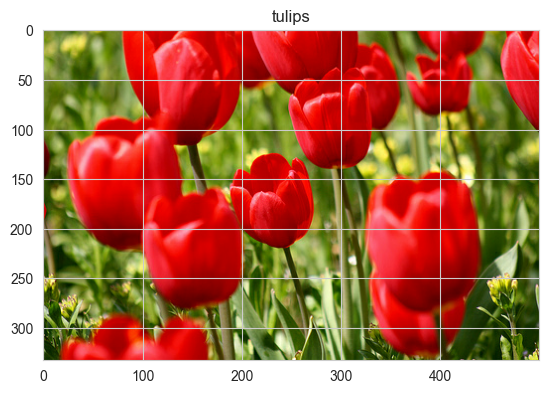

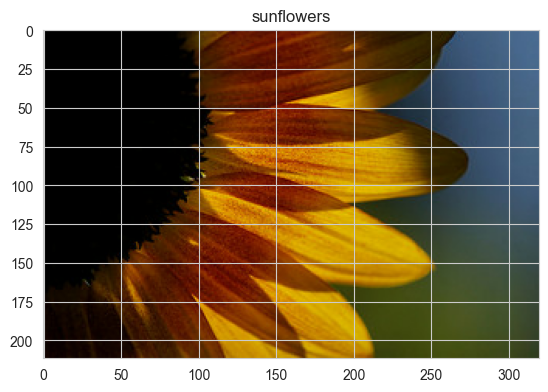

In [6]:
def show_image(image, target):
    plt.imshow(image)
    plt.title(labels[target])
    # plt.axis("off")
    plt.show()


for i in range(2):
    show_image(images[i], targets[i])

Before we can use the data to train neural networks, we need to pre-process the data such that:
    
- the images are all the same shape (224,224)
- the images, originally with values (0, 255), are mapped to have values between (0, 1)
- the labels are represented as one-hot vectors

_Write a function to rescale and resize the images._

In [7]:
def rescale_and_resize(image, dtype=tf.float32):
    image_float = tf.image.convert_image_dtype(image, dtype)
    image_float = tf.image.resize(image_float, (224, 224), method='bilinear')
    return tf.clip_by_value(image_float, 0.0, 1.0)

# rescale_and_resize(images[0]).numpy()

In [8]:
check_var_defined('rescale_and_resize')

rescale_and_resize defined.


_Now use the function to pre-process the data in the variable `images` and save the preprocessed images in an np.ndarray `images_preprocessed`._

In [9]:
from tqdm import tqdm

a = [rescale_and_resize(img).numpy() for img in tqdm(images)]
images_preprocessed = np.stack(a)
images_preprocessed.shape

100%|██████████| 3670/3670 [00:04<00:00, 747.34it/s]


(3670, 224, 224, 3)

In [10]:
check_var_defined('images_preprocessed')
assert type(images_preprocessed) == np.ndarray, "Make sure to store your answer as a np.ndarray"

images_preprocessed defined.


One approach to represent the image labels so that they can be trainable by a neural network is to represented them as a one-hot vector. 

_Write a function `one_hot_encoding` that takes the integer label and returns a one-hot vector of the label._

In [11]:
def one_hot_encoding(target):
    a = np.zeros(len(labels))
    a[target] = 1
    return a


print(f"target: {targets[0]}, encoding: {one_hot_encoding(targets[0])}")

target: 2, encoding: [0. 0. 1. 0. 0.]


_Now use the function `one_hot_encoding` to create an np.ndarray of the one-hot representations of all the labels in `targets` and save them in `targets_preprocessed`._

In [12]:
targets_preprocessed = np.array([one_hot_encoding(t) for t in targets])
targets_preprocessed.shape

(3670, 5)

In [13]:
check_var_defined('targets_preprocessed')
assert type(targets_preprocessed) == np.ndarray, "Make sure to store your answer as a np.ndarray"

targets_preprocessed defined.


In this notebook you will train different models and compare them against each other. 

Now that the data is pre-processed. We will split the data in three datasets, a train, validation and test set. 

_Why do we need these three sets and what do we use them for._

We split the data into three subsets to improve and assess the performance of the model in an fair and unbiased way.

The train set is for training the model, the model parameters are adjusted every epoch to minimize loss.

The validation set is utilized to fine-tune the hyperparameters, such as the learning rate, the number of layers or units in the model, etc.
The model doesn't "see" the validation set and neither trained on it, but it brings insight for me (the model builder) so that I can tune the model according to these extra scores. It indirectly influences the model for it directly influences design decisions.

The test set is used to evaluate the performance of the final model. This set must be a 'never-seen' data for the model, meaning it should be entirely separated from the train and validation sets. Evaluate the model on this set is like a mock test that gives an unbiased estimation of its performance on new data, so to make sure the model performs well in actual deployed user scenarios.

The over all point of dividing the data into three subsets is to mitigate the issues of overfitting, where the model memorizes the training data but struggles with new data, and underfitting, where the model is too simplistic and cannot discern the patterns in the data.

$%answered$

_Now split the data such that we have a train set with 80\% of the samples and a validation and test set each with 10\% of the samples. Save the results in `x_train`, `y_train`, `x_val`, `y_val`, `x_test`, and `y_test`._

In [14]:
tf.keras.utils.set_random_seed(371947)

n = targets_preprocessed.shape[0]
indices = np.arange(n)
rest_size = int(.2 * n)
test_size = rest_size // 2
idxs = np.random.choice(indices, size=rest_size, replace=False)

x_train = images_preprocessed[~idxs, ...]
y_train = targets_preprocessed[~idxs, ...]

x_val = images_preprocessed[idxs[:test_size], ...]
y_val = targets_preprocessed[idxs[:test_size], ...]

x_test = images_preprocessed[idxs[test_size:], ...]
y_test = targets_preprocessed[idxs[test_size:], ...]

print(f"Train samples: {len(x_train)}, Validation samples: {len(x_test)}, Test samples: {len(x_val)}")

Train samples: 734, Validation samples: 367, Test samples: 367


In [15]:
check_var_defined('x_train')
check_var_defined('y_train')

check_var_defined('x_val')
check_var_defined('y_val')

check_var_defined('x_test')
check_var_defined('y_test')

x_train defined.
y_train defined.
x_val defined.
y_val defined.
x_test defined.
y_test defined.


WARNING: Before we continue we delete the variable `images_preprocessed` (you don't need that anymore) to manage our RAM consumption. If you want to use that variable again you will have to rerun the cell that creates it.

In [16]:
# Freeing up RAM by deleting this variable
del images_preprocessed

# Part 2: Training a basic CNN model 

Now that we have pre-processed the data and split it into different parts for training, validation and testing, you can start training some neural networks.

Our model will take as input the $224 \times 224$ rgb (3-channel) images and will give as output a length five vector of which the different elements correspond to the five different classes. 

The model will start with convolutional layers followed by a hidden dense layer and then the final dense layer that gives us our output. 

_What kind of activation function should we use on the convolutional, dense and output layers and why these specific activation functions? (motivate your answers)_


1. Use **ReLU** for **convolutional layers**
    - It sets all negative values to zero without changing positive values, which makes it computationally efficient.

    - It avoids the vanishing gradient problem by maintaining the gradient signal through backpropagation.

2. Use **ReLU** for the **hidden dense layer**

    - Despite its simplicity and efficiency, and the benefit of preventing gradient vanishing problem;
    - It also adds sparsity to the intermediate output (e.i., many zeros), which can help with regularization and prevent overfitting.

3. Use **Softmax** for the **output Layer**
    - Softmax converts the output of the last dense layer into a probability distribution over the classes, ensuring that the sum of the probabilities is equal to one.

$%answered$

_Create a model using the `tf.keras.models.Sequential()` model and add to that:_

- Input layer: A 2D convolutional layer with 8 filters, a 3x3 kernel and the ReLU activation function. Specify that this layer has an `input_shape` of (224, 224, 3)_ 
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 16 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 32 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A 2D convolutional layer with 32 filters, a 3x3 kernel and a the ReLU activation function
- A 2D MaxPool layer with strides 2x2

- A Flatten layer to flatten the filters to a single vector
- A Dense layer with 32 nodes and your chosen activation

- Output layer: A Dense layer with 5 nodes and your chosen activation

_Store the model in the variable `model_basic`._

In [17]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(93612)
kernel_size = (3, 3)
stride = (2, 2)

model_basic = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(8, kernel_size, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(16, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Conv2D(32, kernel_size, activation='relu'),
    tf.keras.layers.MaxPooling2D(stride),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

In [18]:
check_var_defined('model_basic')

model_basic defined.


To compile the model we need to specify a loss function. 

_What loss function would be appropriate for this multi-class classfication problem?_

_Also, during training we would like to monitor how well our model performs on predicting the targets. What would be a good metric to track? Motivate your answers._ 

For the loss, the `CategoricalCrossentropy()` loss would be appropriate. The categorical cross-entropy loss function is widely used for multi-class classification problems as it calculates the difference between the predicted probability distribution and the true probability distribution. This loss function is suitable for this problem because it measures the dissimilarity between the true and predicted class probabilities.

As for the metric to track during training, accuracy would be a good choice. Since we are dealing with a multi-class classification problem, we can use `CategoricalAccuracy()`, which calculates the average accuracy rate across all classes. It is an intuitive and easy-to-understand metric that can be used to evaluate the overall performance.
$%answered$

Now compile the model using the `Adam` optimiser, your chosen loss, and your chosen metric to track. (Tip: TF has some loss function and metrics implemented in [tf.keras.losses](https://www.tensorflow.org/api_docs/python/tf/keras/losses) and [tf.keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).)

In [19]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

model_basic.compile(optimizer=Adam(),
                    loss=CategoricalCrossentropy(),
                    metrics=[CategoricalAccuracy()])


In [20]:
check_var_defined('model_basic')

model_basic defined.


_Now fit the train data for 10 epochs and save the training history in the variable `history_basic`. Also specify the `validation_data` and a `batch_size` of 32._

In [21]:
tf.keras.utils.set_random_seed(47290)
history_basic = model_basic.fit(x_train, y_train,
                                epochs=10,
                                batch_size=32,
                                validation_data=(x_val, y_val))


Epoch 1/10
23/23 [==============================] - 7s 51ms/step - loss: 1.5745 - categorical_accuracy: 0.3215 - val_loss: 1.4608 - val_categorical_accuracy: 0.3787
Epoch 2/10
23/23 [==============================] - 1s 29ms/step - loss: 1.3679 - categorical_accuracy: 0.4033 - val_loss: 1.3936 - val_categorical_accuracy: 0.3815
Epoch 3/10
23/23 [==============================] - 1s 28ms/step - loss: 1.2217 - categorical_accuracy: 0.4755 - val_loss: 1.2458 - val_categorical_accuracy: 0.4387
Epoch 4/10
23/23 [==============================] - 1s 28ms/step - loss: 1.1692 - categorical_accuracy: 0.5191 - val_loss: 1.2174 - val_categorical_accuracy: 0.4550
Epoch 5/10
23/23 [==============================] - 1s 28ms/step - loss: 1.0589 - categorical_accuracy: 0.5845 - val_loss: 1.1129 - val_categorical_accuracy: 0.5450
Epoch 6/10
23/23 [==============================] - 1s 24ms/step - loss: 1.0196 - categorical_accuracy: 0.5708 - val_loss: 1.1167 - val_categorical_accuracy: 0.5422
Epoch 7/10

In [22]:
check_var_defined('history_basic')

history_basic defined.


_Now to see how the model performs, write a function `plot_metrics` that plots the loss for the train and validation set. In the same function also create a separate plot that plots the other metric for the train and validation set._

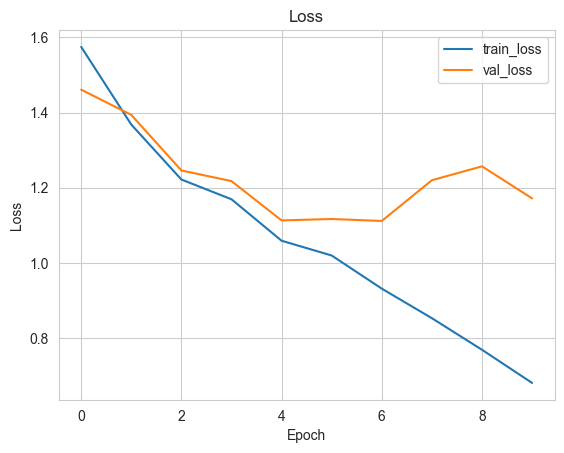

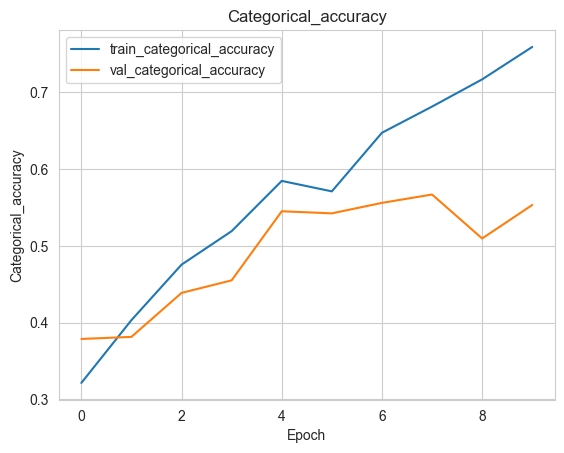

In [23]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy']
    for metric in metrics:
        # plot loss
        plt.plot(history.history[metric], label=f'train_{metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.show()

    # plot accuracy
    # plt.plot(history.history['categorical_accuracy'], label='train_accuracy')
    # plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
    # plt.title('Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.legend()
    # plt.show()


plot_metrics(history_basic)

_Comment on the performance of the model based the tracked loss and metric_

Based on the tracked loss and metric, it appears that the model is improving its ability to classify the data.

The training loss is steadily decreasing, which suggests that the model is learning to better fit the training data; the training accuracy is steadily increasing, indicating that the model is becoming more accurate at predicting the correct classes for the training data.

However, the validation loss and accuracy do not show such steady improving trends comparing with train loss and accuracy. It seems to fluctuate more and even decrease slightly after some epochs.

This suggests that the model may be overfitting the training data, meaning that it is becoming too specialized to the training set and unable to generalize well to new, unseen data. To address this, further regularization techniques may need to be applied, such as dropout or weight decay.

Overall, while the training performance is encouraging, more attention needs to be paid to the validation performance, and further improvements may be necessary to achieve better generalization to new data.

*What happens if we were to train the model for more epochs? What will happen to the performance of the model?*

For the first few more epoches, the loss on the training set will continue to decrease and the accuracy on the validation set will continue to increase slightly fluctuations.

But after training for too many epochs, the loss on the training set will stop decreasing, and the accuracy on the validation set will stop improving or even starts to decrease. This indicates that the model has reached its optimal performance, and continuing training would just result in overfitting to the train data, leading to worse performance on new, unseen data(e.g., the test datset).
$%answered$

*Write a function `model_predict` that takes the model and some image data and returns the predicted targets (as integers corresponding to the predicted labels).* 

In [48]:
def model_predict(model, data):
    return np.argmax(model.predict(data), axis=1)

_Gather the targets of the test set (scalar integer value corresponding to the labels) and save them in `test_targets`._

_Compute the targets for `model_basic` and store them in the variable `test_targets_basic`._

In [53]:
test_targets = np.where(y_test != 0)[1]
test_targets_basic = model_predict(model_basic, x_test)

12/12 [==============================] - 0s 9ms/step


In [54]:
check_var_defined('test_targets')
check_var_defined('test_targets_basic')

assert test_targets.ndim == 1, "Make sure you are only predicting the scalar label value not the one hot vectors"
assert test_targets_basic.ndim == 1, "Make sure you are only predicting the scalar label value not the one hot vectors"

test_targets defined.
test_targets_basic defined.


_Calculate the precision and recall averaged over the 5 classes. (Precision and recall for each classes and then avaraged in one score)_

In [86]:
from sklearn.metrics import precision_score, recall_score


def average_recall_precision(y, y_predict):
    precision = precision_score(y, y_predict, average=None)
    recall = recall_score(y, y_predict, average=None)
    print(f'precision:\n{precision}')
    print(f'recall:\n{recall}')
    precision = np.mean(precision)
    recall = np.mean(recall)
    print(f"\nAverage Recall: {recall:.3f}, Average Precision {precision:0.3f}")
    return recall, precision


recall_basic, precision_basic = average_recall_precision(test_targets, test_targets_basic)

precision:
[0.54744526 0.5625     0.52380952 0.5625     0.62      ]
recall:
[0.74257426 0.14285714 0.57142857 0.77586207 0.45588235]

Average Recall: 0.538, Average Precision 0.563


In [82]:
check_var_defined('recall_basic')
check_var_defined('precision_basic')

recall_basic defined.
precision_basic defined.


_Show the predicted targets in a confusion matrix. Show the predicted labels in percentages (percentage of the samples from true class labeled as predicted class) and add the labels to the axes._

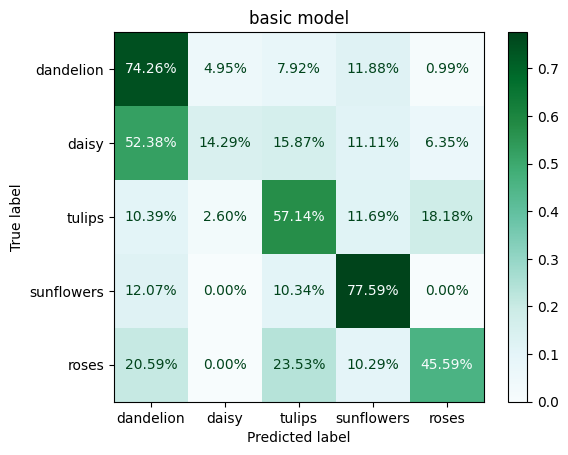

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_confusion_matrix(y, y_pred, title=""):
    cm = confusion_matrix(y, y_pred, normalize='true')  # todo
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(values_format='.2%', cmap='BuGn')
    plt.title(title)
    plt.show()
    return cm


cm = plot_confusion_matrix(test_targets, test_targets_basic, "basic model")

_Comment on the recall and precision of the model, as well as the predictions in the confusion matrix._

# recall and precision
The recall and precision scores provide an insight into the performance of a classification model. The recall score represents the model's ability to correctly identify all relevant samples, while the precision score shows how often the model correctly identified positive samples.

The average recall score tells us how only 53.8% of the samples that actually belong is a certain type of flower were correctly predicted by the model as being that type of flower.
The averaged precision score tells us 56.3% of the samples that the model predicted to be as a certain flower actually is that type of flower.

The model's performance is only slightly better than random guessing, who would have an average recall and precision score of 0.2 (assuming a balanced dataset). Therefore, the model still needs improvements.

# predictions in confusion matrix
The model demonstrates satisfactory performance for certain classes.
- For example, the model performs quite well for dandelions, with a recall of 74.26%, signifying its ability to distinguish dandelions from other flowers .
- The same goes for sunflowers as well, for the relatively accurate predicts(77.6%).

However, it appears that the model struggles to distinguish between certain classes.
- Specifically, more than half (52.38%) of daisies are wrongly identified as dandelions, meaning that the model tends to mistaken daisies as dandelions.
- Additionally, the model exhibits poor performance in recognizing roses, with a recall of only 45.6%, indicating its inability to accurately capture the key features of roses.

The confusion matrix indicates that the model has some difficulty distinguishing between certain classes,and has not learnt essential features for certain categories.

Overall, both the scores and matrix suggest that the model is not performing very well, and could benefit from training with more data.

# Part 3: Improving the model

To improve on the model we will include some Dropout layers. 

_What do dropout layers do and why might this increase the performance of our models?_

Dropout layers are a regularization technique used in neural networks to prevent overfitting. Dropout is applied during training and works by randomly "dropping out" (setting to zero) a certain percentage of the neurons in a layer, with the dropout rate usually set between 0.2 and 0.5.

By randomly dropping out neurons during training, dropout forces the network to learn more robust and generalized features, since each neuron must learn to make predictions in the absence of other neurons that may have become co-adapted. Dropout also acts as a form of ensemble learning, since each time the network is trained, a different set of neurons is dropped out, resulting in slightly different predictions. This can help to reduce overfitting and improve the generalization performance of the network on new, unseen data.

In summary, dropout layers help to prevent overfitting and improve the generalization performance of the model by randomly dropping out neurons during training, forcing the network to learn more robust and generalized features.
$%answered?$

Another method to improve the model is by using a technique called data augmentation. 

_Explain the concept data augmentation and explain how it might increase the performance of our model._

YOUR ANSWER HERE

_Use the exact same model as for the `model_basic`, but play around with adding in a data augmentation layer (e.g. [tf.keras.layers.RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip) ) and adding in dropout layers (dropout is typically only added in the dense part of the network). Store the new model in the variable `model_dropout` and compile it using the same metrics and loss as before._

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(48263)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
check_var_defined('model_dropout')

_Fit the new model in the same way as before and save the history in `history_dropout`. However, train for 20 epochs instead of 10._

In [ ]:
tf.keras.utils.set_random_seed(103745)
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
check_var_defined('history_dropout')

In [ ]:
plot_metrics(history_dropout)

_Comment on the performance of the improved model based on the loss and metrics during training._

YOUR ANSWER HERE

_Why did we have to train the model for longer than the basic model?_

YOUR ANSWER HERE

Now we evaluate our model on the test set using the functions you wrote before

In [ ]:
test_targets_dropout = model_predict(model_dropout, x_test)
recall_dropout, precision_dropout = average_recall_precision(test_targets, test_targets_dropout)
plot_confusion_matrix(test_targets, test_targets_dropout, "Dropout model")

In [ ]:
check_var_defined('test_targets_dropout')
check_var_defined('recall_dropout')

In [ ]:
check_var_defined('test_targets_dropout')
check_var_defined('precision_dropout')

_Comment on the precision and recall of the model as well as the predictions in the confusion matrix_

YOUR ANSWER HERE

# Part 4: Transfer learning

In order to improve our model even further, we will make use of transfer learning. 

_Explain in your own words what tranfer learning means and why it would help in our particular case._

YOUR ANSWER HERE

Below you can see how we load in a pre-trained MobileNet that is trained on the ImageNet datastet. By not including the top part of the network we get only the convolutional layers and can add our own dense layers after that. We set all the layers of the MobileNet as not trainable, since this would be computationally expensive to do and we also want to avoid overfitting. Instead we will only be training the dense part. 

In [ ]:
mobilenet = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in mobilenet.layers:
    layer.trainable = False

print("Output shape of the MobileNet: ", mobilenet.output_shape)

_Use a sequential model and add the MobileNet, followed by a MaxPool2D layer, and then the dense part of the network which you can use the same as we have used in the previous models. Store the model in the variable `model_mobilenet`. Compile the model using the same metrics, loss and optimiser as before._

In [ ]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(387453)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
check_var_defined('model_mobilenet')

*Train the model in the same way as before, for 10 epochs.*

In [ ]:
tf.keras.utils.set_random_seed(9673)
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
check_var_defined('history_mobilenet')

In [ ]:
plot_metrics(history_mobilenet)

In [ ]:
test_targets_mobilenet = model_predict(model_mobilenet, x_test)
recall_mobilenet, precision_mobilenet = average_recall_precision(test_targets, test_targets_mobilenet)
plot_confusion_matrix(test_targets, test_targets_mobilenet, "Mobilenet model")

In [ ]:
check_var_defined('test_targets_mobilenet')
check_var_defined('recall_mobilenet')


In [ ]:
check_var_defined('precision_mobilenet')


_Comment on the results from the transfer-learned model and why the results differ to the case considered previously without transfer learning._

YOUR ANSWER HERE

_Suggest some ways the model could be improved further._

YOUR ANSWER HERE